In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/HoViT

CRC-VAL-HE-7K  NCT-CRC-HE-100K	test  train


In [ ]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=4a4a16b5cd5f74f78dab42606700767c6f7d589f32a5199bdfb6780304cf4f13
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-01-22 00:37:23--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-01-22 00:37:24--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip  89%[================>   ]  

In [ ]:
!pip install torchinfo

import cv2
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torch import profiler
from torchinfo import summary

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [ ]:
model = timm.create_model('vit_base_patch8_224', pretrained=False, num_classes=9)

print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
batch_size = 32
learning_rate = 5e-4
decay_rate = 1e-6
num_epochs = 30

In [ ]:
print(summary(model, input_size=(32, 3, 224, 224)))

In [ ]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
train_dir = './train/NCT-CRC-HE-100K'
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [ ]:
data_paths, labels = zip(*dataset.samples)
labels = np.array(labels)

# 7 : 3 split
train_idx, tmp_idx, _, tmp_labels = train_test_split(
    np.arange(len(labels)), labels, test_size=0.3, stratify=labels, random_state=42
)

# 3 -> 1.5 : 1.5 split
val_idx, test_idx = train_test_split(
    tmp_idx, test_size=0.5, stratify=tmp_labels, random_state=42
)

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

In [ ]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(dataset.classes):
            break
    if len(class_examples) == len(dataset.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(dataset.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = decay_rate)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)


In [ ]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [ ]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [19]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [33:52<00:00,  1.08it/s]


Train Loss: 2.0551, Train Accuracy: 21.69%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 1.8609, Validation Accuracy: 31.36%
Balanced Accuracy: 0.3120

Epoch 2/30


Training: 100%|██████████| 2188/2188 [33:52<00:00,  1.08it/s]


Train Loss: 1.7684, Train Accuracy: 33.96%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 1.6386, Validation Accuracy: 38.27%
Balanced Accuracy: 0.3736

Epoch 3/30


Training: 100%|██████████| 2188/2188 [33:50<00:00,  1.08it/s]


Train Loss: 1.6136, Train Accuracy: 39.71%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 1.5144, Validation Accuracy: 44.02%
Balanced Accuracy: 0.4237

Epoch 4/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 1.5239, Train Accuracy: 43.50%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 1.4896, Validation Accuracy: 43.97%
Balanced Accuracy: 0.4314

Epoch 5/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 1.2522, Train Accuracy: 53.05%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 1.3020, Validation Accuracy: 52.07%
Balanced Accuracy: 0.5100

Epoch 6/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 1.1291, Train Accuracy: 57.99%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 1.0198, Validation Accuracy: 61.62%
Balanced Accuracy: 0.6070

Epoch 7/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 1.0148, Train Accuracy: 62.18%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.9363, Validation Accuracy: 65.47%
Balanced Accuracy: 0.6436

Epoch 8/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.9377, Train Accuracy: 65.19%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.9377, Validation Accuracy: 64.96%
Balanced Accuracy: 0.6319

Epoch 9/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.8515, Train Accuracy: 68.26%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.7779, Validation Accuracy: 71.27%
Balanced Accuracy: 0.7084

Epoch 10/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.8062, Train Accuracy: 69.94%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.9470, Validation Accuracy: 65.54%
Balanced Accuracy: 0.6619

Epoch 11/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.9271, Train Accuracy: 65.89%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.7846, Validation Accuracy: 71.02%
Balanced Accuracy: 0.7043

Epoch 12/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.8957, Train Accuracy: 67.03%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.7322, Validation Accuracy: 73.47%
Balanced Accuracy: 0.7288

Epoch 13/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.7199, Train Accuracy: 73.58%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.6741, Validation Accuracy: 75.12%
Balanced Accuracy: 0.7417

Epoch 14/30


Training: 100%|██████████| 2188/2188 [33:50<00:00,  1.08it/s]


Train Loss: 0.6810, Train Accuracy: 75.02%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.8458, Validation Accuracy: 69.16%
Balanced Accuracy: 0.6865

Epoch 15/30


Training: 100%|██████████| 2188/2188 [33:50<00:00,  1.08it/s]


Train Loss: 0.7670, Train Accuracy: 71.94%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]


Validation Loss: 0.8495, Validation Accuracy: 68.63%
Balanced Accuracy: 0.6833

Epoch 16/30


Training: 100%|██████████| 2188/2188 [33:50<00:00,  1.08it/s]


Train Loss: 0.7502, Train Accuracy: 72.58%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.7753, Validation Accuracy: 71.45%
Balanced Accuracy: 0.7120

Epoch 17/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.7413, Train Accuracy: 72.77%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.8608, Validation Accuracy: 68.66%
Balanced Accuracy: 0.6858

Epoch 18/30


Training: 100%|██████████| 2188/2188 [33:52<00:00,  1.08it/s]


Train Loss: 0.7268, Train Accuracy: 73.33%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.7657, Validation Accuracy: 71.74%
Balanced Accuracy: 0.7068

Epoch 19/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.6796, Train Accuracy: 75.01%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.6489, Validation Accuracy: 76.10%
Balanced Accuracy: 0.7506

Epoch 20/30


Training: 100%|██████████| 2188/2188 [33:52<00:00,  1.08it/s]


Train Loss: 0.6396, Train Accuracy: 76.33%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.6471, Validation Accuracy: 76.50%
Balanced Accuracy: 0.7636

Epoch 21/30


Training: 100%|██████████| 2188/2188 [33:52<00:00,  1.08it/s]


Train Loss: 0.5778, Train Accuracy: 78.65%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.5526, Validation Accuracy: 79.67%
Balanced Accuracy: 0.7879

Epoch 22/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.6045, Train Accuracy: 77.87%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.5895, Validation Accuracy: 78.39%
Balanced Accuracy: 0.7808

Epoch 23/30


Training: 100%|██████████| 2188/2188 [33:50<00:00,  1.08it/s]


Train Loss: 0.5976, Train Accuracy: 78.12%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.5966, Validation Accuracy: 78.20%
Balanced Accuracy: 0.7744

Epoch 24/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.6327, Train Accuracy: 76.96%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.6373, Validation Accuracy: 76.53%
Balanced Accuracy: 0.7517

Epoch 25/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.6524, Train Accuracy: 76.09%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.6354, Validation Accuracy: 76.59%
Balanced Accuracy: 0.7639

Epoch 26/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.6509, Train Accuracy: 76.12%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.6296, Validation Accuracy: 76.91%
Balanced Accuracy: 0.7605

Epoch 27/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.6717, Train Accuracy: 75.35%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.6281, Validation Accuracy: 76.84%
Balanced Accuracy: 0.7728

Epoch 28/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.6271, Train Accuracy: 76.97%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.7442, Validation Accuracy: 73.65%
Balanced Accuracy: 0.7377

Epoch 29/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.5862, Train Accuracy: 78.43%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]


Validation Loss: 0.5475, Validation Accuracy: 80.33%
Balanced Accuracy: 0.8012

Epoch 30/30


Training: 100%|██████████| 2188/2188 [33:51<00:00,  1.08it/s]


Train Loss: 0.5342, Train Accuracy: 80.55%


Validation: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]

Validation Loss: 0.5032, Validation Accuracy: 81.25%
Balanced Accuracy: 0.8061


In [20]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [02:32<00:00,  3.08it/s]

Test Loss: 0.5102, Test Accuracy: 81.72%
Balanced Accuracy: 0.8104


In [ ]:
print("train_loss length : ", len(train_losses))
print("train_acc length : ", len(train_accuracies))
print("val_loss length : ", len(val_losses))
print("val_acc length : ", len(val_accuracies))

print("val_adj : ", len(val_losses[:num_epochs]))
print("val_acc_adj : ", len(val_accuracies[:num_epochs]))

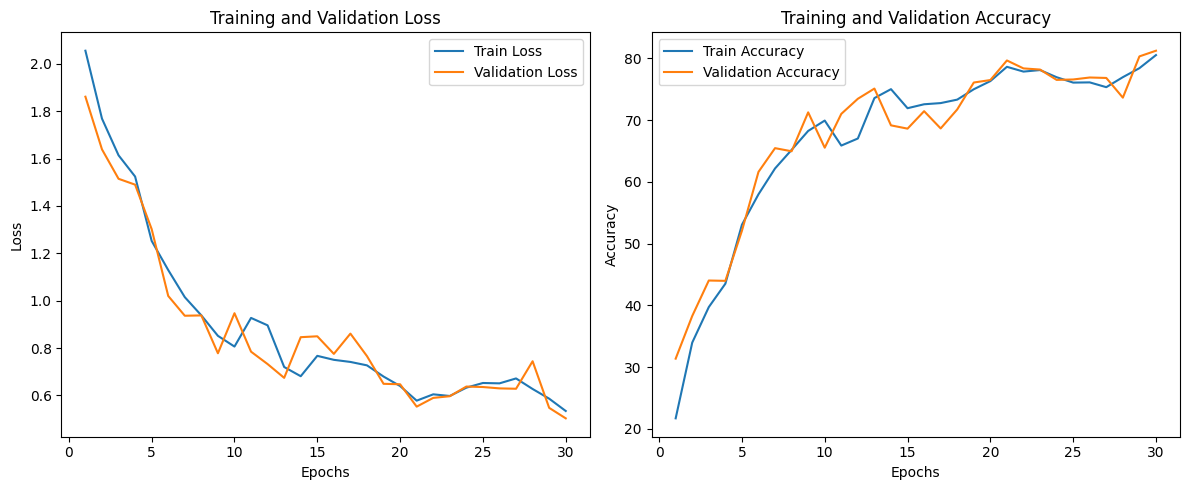

In [22]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses[:num_epochs], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies[:num_epochs], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 282.60 ms
Standard Deviation: 3.07 ms
Maximum Time: 283.03 ms
Minimum Time: 216.18 ms


In [ ]:
dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

In [ ]:
save_path = "./content/drive/MyDrive/HoViTViT_patch8_NCT_CRC_HE.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [ ]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device, phase="Test")

In [ ]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [ ]:
fpr, tpr, roc_auc_value = roc_auc(model, test_loader, device, num_classes=9)

In [ ]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )